Programming excercises from Rasmussen and Williams GP book

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
from scipy.special import expit as sigmoid

In [155]:
def rbf_kernel(x_1, x_2):
    """Return covariance kernel exp(-1/2|x_1p - x_2q|**2) for two vectors x_1, x_2"""
    sq_dist = np.sum(x_1**2, 1).reshape(-1, 1) + np.sum(x_2**2, 1) - 2*np.dot(x_1, x_2.T)
    return np.exp(-(0.5) * sq_dist) 

In [156]:
def Gaussian(mean, cov, num_samples):
    L = np.linalg.cholesky(cov + 1e-6*np.eye(cov.shape[0]))
    samples = np.random.multivariate_normal(np.zeros(mean.shape), np.eye(cov.shape[0]), size=num_samples)
    return mean[:,None] + np.dot(L,samples.T)

## Laplace Method

In [389]:
def mode_finding_laplace(cov, y, lk_fn, max_iters=10):
       
    f = np.zeros_like(y)
    obj = 0
    for i in range(max_iters):
        W = -lk_fn(y,f)[2]
        W_sqrt = W**(1/2)
        L = np.linalg.cholesky(np.eye(y.shape[0]) + (W_sqrt).dot(cov).dot(W_sqrt))

        b = W.dot(f) + lk_fn(y,f)[1]

        a = b - (W_sqrt).dot(np.linalg.solve(L.T,np.linalg.solve(L,(W_sqrt).dot(cov).dot(b))))

        f = cov.dot(a)
        
        if (np.abs(obj - (-1/2 * a.T.dot(f) + lk_fn(y,f)[0])) < 1e-9).any():
            break
        obj = (-1/2 * a.T.dot(f) + lk_fn(y,f)[0])
                
    log_q = -1/2 * a.T.dot(f) + lk_fn(y,f)[0] - np.trace(L)
    
    return f, log_q

In [378]:
def laplace_predictions(mode, X, y, k, lk_fn, x_star):
    W = -lk_fn(y,mode)[2]
    W_sqrt = W**(1/2)
    L = np.linalg.cholesky(np.eye(y.shape[0]) + (W_sqrt).dot(cov).dot(W_sqrt))
    pi_stars = []
    for x_s in x_star:
        x_s = np.array(x_s).reshape(1,-1)
        f_star = k(X,x_s).T.dot(lk_fn(y,mode)[1])
        v = np.linalg.solve(L,W_sqrt.dot(k(X,x_s)))
        var_f = k(x_s,x_s) - v.T.dot(v)

        pi_star = sum([sigmoid(z) for z in Gaussian(f_star,var_f, 1000)[0,:]])/1000
        pi_stars.append(pi_star)
        
    return pi_stars

In [237]:
def sigmoid_lf_fn(y,f):
    '''
    returns likelihood function and first and second derivatives
    '''
    t = (y+1)/2
    pi = sigmoid(f)
    
    
    lk = -np.log(1 + np.exp(-y * f))
    d_lk = (t-pi)
    d2_lk = -np.diag((pi*(1-pi)).ravel())

    
    return lk, d_lk, d2_lk

In [395]:
def normal_cdf_lf_fn(y,f):
    '''
    returns likelihood function and first and second derivatives
    '''
    t = (y+1)/2
    pi = norm.cdf(f)

    
    lk = np.log(norm.cdf(y*f))
    d_lk = y * norm.pdf(f) / norm.cdf(y*f)
    d2_lk = np.diag((-norm.pdf(f)**2 / norm.cdf(y*f)**2 - y * f * norm.pdf(f) / norm.cdf(y*f)).ravel())
    
    return lk, d_lk, d2_lk

In [239]:
def generate_dataset(size, classes=2, noise=0.5):
    # Generate random datapoints
    labels = np.random.randint(0, classes, size)
    x = (np.random.rand(size) + labels) / classes
    y = x + np.random.rand(size) * noise
    # Reshape data in order to merge them
    x = x.reshape(size, 1)
    y = y.reshape(size, 1)
    labels = labels.reshape(size, 1)
    # Merge the data
    data = np.hstack((x, y, labels))
    return data

## RBF Kernel

### Sigmoid Likelihood Function

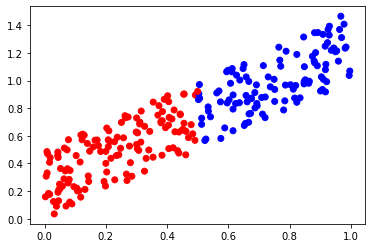

In [382]:
data = generate_dataset(500)
x_1 = data[:250,0]
x_2 = data[:250,1]
X = data[:250,:2]
y = data[:250,2]
y[y==0] = -1
plt.scatter(x_1,x_2,c=y,cmap=matplotlib.colors.ListedColormap(['red', 'blue']))

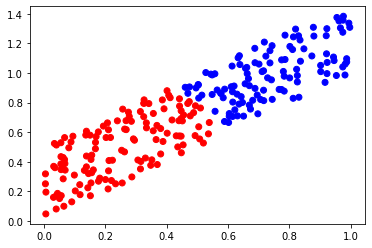

In [383]:
cov = rbf_kernel(X,X)

mode, log_q = mode_finding_laplace(cov, y, sigmoid_lf_fn)

#test = generate_dataset(50)

test_x = data[250:,:2]

pi = laplace_predictions(mode, X, y, rbf_kernel, sigmoid_lf_fn, test_x)




x_1 = test_x[:,0]
x_2 = test_x[:,1]

y = np.array(pi)
y[y>0.5] = 1
y[y<=0.5] = -1
plt.scatter(x_1,x_2,c=y,cmap=matplotlib.colors.ListedColormap(['red', 'blue']))

### Probit Likelihood Function

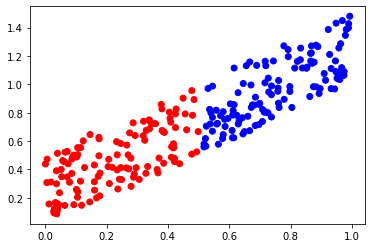

In [396]:
data = generate_dataset(500)
x_1 = data[:250,0]
x_2 = data[:250,1]
X = data[:250,:2]
y = data[:250,2]
y[y==0] = -1
plt.scatter(x_1,x_2,c=y,cmap=matplotlib.colors.ListedColormap(['red', 'blue']))

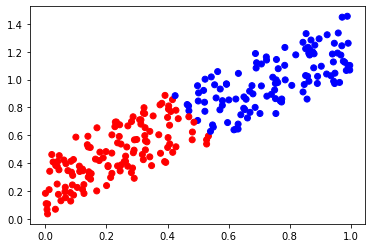

In [397]:
cov = rbf_kernel(X,X)

mode, log_q = mode_finding_laplace(cov, y, normal_cdf_lf_fn)

#test = generate_dataset(50)

test_x = data[250:,:2]

pi = laplace_predictions(mode, X, y, rbf_kernel, normal_cdf_lf_fn, test_x)




x_1 = test_x[:,0]
x_2 = test_x[:,1]

y = np.array(pi)

y[y>0.5] = 1
y[y<=0.5] = -1
plt.scatter(x_1,x_2,c=y,cmap=matplotlib.colors.ListedColormap(['red', 'blue']))

## Expectation Propagation